In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import pdb

In [2]:
#estaciones = [ 'BOLIVIA','CARVAJAL', 'CIUDAD BOLIVAR', 'FONTIBON', 'GUAYMARAL', 'JAZMIN','LAS FERIAS','MIN AMBIENTE','PUENTE ARANDA','SAN CRISTOBAL','SUBA','USAQUEN','CENTRO DE ALTO RENDIMIENTO', 'JAZMIN', 'TUNAL', 'KENNEDY', 'USME','PUENTE ARANDA']
# Nombres de las variables
#estacionesB= ['CENTRO DE ALTO RENDIMIENTO', 'JAZMIN', 'TUNAL', 'KENNEDY', 'USME','PUENTE ARANDA']

In [3]:
# Lista de nombres de estaciones
estaciones = ['BOLIVIA', 'CARVAJAL', 'CIUDAD BOLIVAR', 'FONTIBON', 'GUAYMARAL', 'JAZMIN', 'LAS FERIAS', 'MIN AMBIENTE', 'PUENTE ARANDA', 'SAN CRISTOBAL', 'SUBA', 'USAQUEN', 'CENTRO DE ALTO RENDIMIENTO', 'JAZMIN', 'TUNAL', 'KENNEDY', 'USME', 'PUENTE ARANDA']

In [13]:
directorio = 'Predicciones'  # Ruta al directorio de los archivos CSV

for estacion in estaciones:
    nombre_archivo = f'nuevo_prediccion_estacion_{estacion}.csv'
    ruta_archivo = os.path.join(directorio, nombre_archivo)
    
    df = pd.read_csv(f'DATA_ORIGINAL/O3.csv')
    df['FECHA'] = pd.to_datetime(df['FECHA'], dayfirst=True)
    df.set_index('FECHA', inplace=True)
    
    # Limpiar datos
    df.replace([0, 9999.], np.nan, inplace=True)
    df.sort_index(inplace=True)
    #df['Time'] = pd.to_datetime(df['FECHA'])
    promedio_8horas = df.resample('8h').mean().resample('d').max()
    promedio_8horas['FECHA'] = promedio_8horas.index
    promedio_mensual = promedio_8horas
    
    # Guardar el DataFrame resultante en un nuevo archivo CSV
    nuevo_nombre_archivo = f'Promedio_{nombre_archivo}'
    promedio_mensual.to_csv(os.path.join(directorio, nuevo_nombre_archivo), index=False)

In [7]:
promedio_8horas.max()

BOLIVIA                                  25.41525
CARVAJAL                                  45.6375
CENTRO DE ALTO RENDIMIENTO                  74.05
CIUDAD BOLIVAR                           43.26575
FONTIBON                                  64.4375
GUAYMARAL                                  65.125
JAZMIN                                   48.06125
KENNEDY                                   62.7625
LAS FERIAS                                   57.6
MIN AMBIENTE                              91.9875
PUENTE ARANDA                             44.1125
SAN CRISTOBAL                             56.0125
SUBA                                        67.65
TUNAL                                     46.1875
USAQUEN                                      67.9
USME                                     47.51025
COLINA                                  28.787333
MOVIL FONTIBON                             41.223
Fecha                         2022-12-31 00:00:00
dtype: object

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import NullFormatter
from sklearn.metrics import r2_score,mean_squared_error

# Directorio con los archivos CSV
directory = 'Predicciones/'

# Crear una lista para almacenar los resultados de los errores
resultados = []

# Función para calcular los errores
def errors(M, O, umbral):
    M_RAYA = np.mean(M)
    O_RAYA = np.mean(O)
 
    bias=np.mean(M)-np.mean(O)
    r = np.corrcoef(O, M)

    nmb = (np.sum(M - O)/np.sum(O)) * 100
    rmse = np.sqrt(np.mean((O - M) ** 2))
    #fac2 = len([i for i in  M/O  if 0.5 <= i and i <=2])/ len(M)
    #fac2 = (1 if 0.5 <= M/O <= 2 else 0) * 100
    fac2 = len((0.5 <= M/O) & (M/O <= 2))/len(M)
    fac2= fac2* 100
   
    ioa = 1 - (np.sum((M - O)**2))/np.sum((np.abs(M - O_RAYA) + np.abs(O - O_RAYA))**2) 
    mb = np.mean((M - O))
    rho = stats.spearmanr(M,O)
    
    na = np.count_nonzero((O < umbral) & (M > umbral))
    nb = np.count_nonzero((O > umbral) & (M > umbral))
    nc = np.count_nonzero((O < umbral) & (M < umbral))
    nd = np.count_nonzero((O > umbral) & (M < umbral))
    #na = len([i for i in np.arange(0,len(M),1) if O[i] < umbral and M[i] > umbral])
    #nb = len([i for i in np.arange(0,len(M),1) if O[i] > umbral and M[i] > umbral])
    #nc = len([i for i in np.arange(0,len(M),1) if O[i] < umbral and M[i] < umbral])
    #nd = len([i for i in np.arange(0,len(M),1) if O[i] < umbral and M[i] < umbral]) 
    
    if nb + nd > 0:  
        hit = (nb/(nb + nd))*100
    else:
        hit = 0
    if na + nb > 0:
        far = (na/(na + nb))*100
    else:
        far = 0
    if na + nb + nc + nd > 0:
        poc = ((nb + nc)/(na + nb + nc + nd))*100
    else:
        poc = 0

    return(round(nmb,2),round(rmse,2),round(rho[0],2),round(fac2,2),round(ioa,2),
           round(mb,2),round(hit,2),round(far,2),round(poc,2))

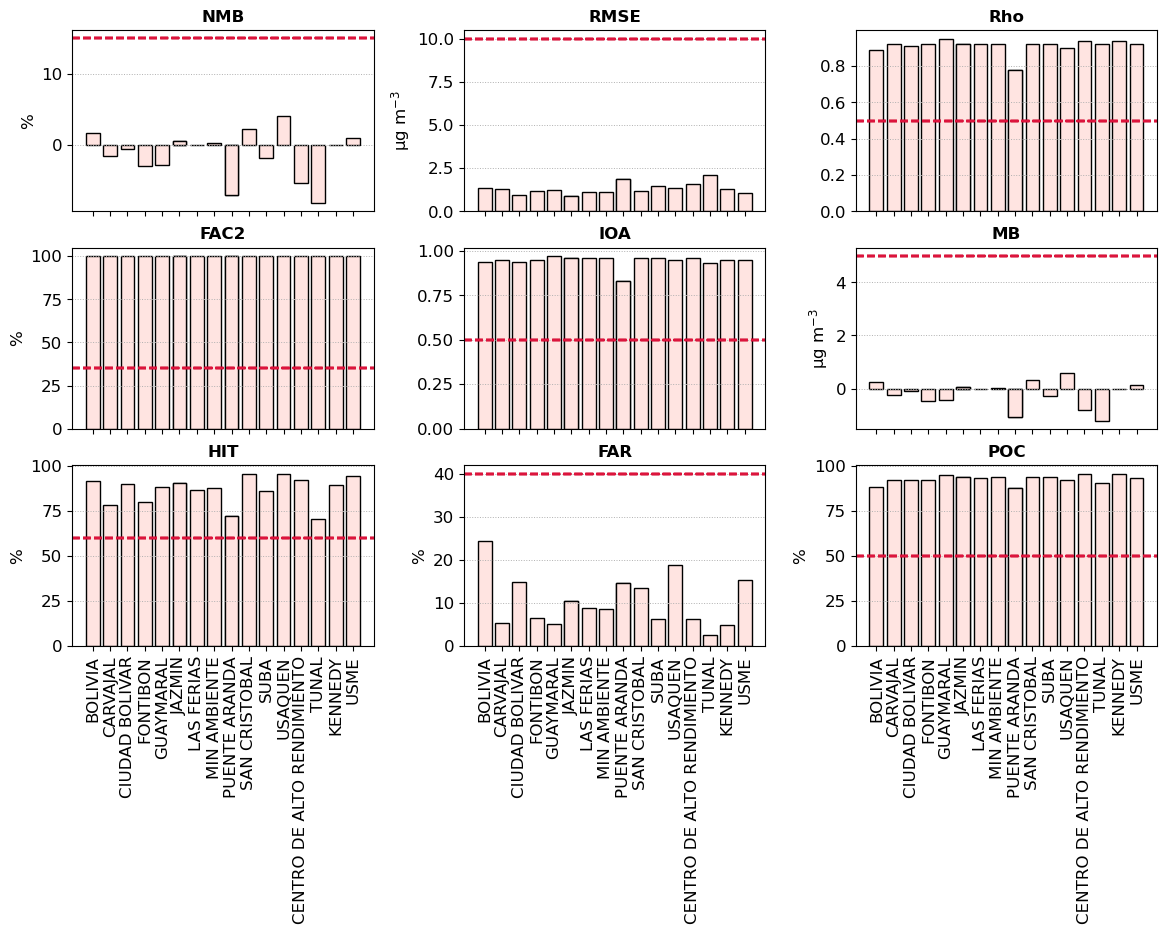

In [33]:
# Crear un diccionario para almacenar los resultados de errores
errores = ['NMB', 'RMSE', 'Rho', 'FAC2', 'IOA', 'MB', 'HIT', 'FAR', 'POC']
threshold = [20] * len(estaciones)
dic_error = {}
bench = [15, 10, 0.5, 35, 0.5, 5, 60, 40, 50]
units = ['%','\u03bcg m$^{-3}$','','%','','\u03bcg m$^{-3}$','%','%','%']

for estacion in estaciones:
    file_path = os.path.join(directory, f'prediccion_estacion_{estacion}.csv')
    df = pd.read_csv(file_path, sep=',', decimal='.')
    obs = df['Real']
    cams = df['Prediccion'] 
    erro = errors(cams, obs, np.percentile(obs,70))

    dic_error[estacion] = erro

nerr = len(errores)
xla_pr = len(estaciones)

fig, axs = plt.subplots(3, 3, figsize=(14, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.2)

for k in range(nerr):
    i, j = divmod(k, 3)
    for estacion in estaciones:
        erro = dic_error[estacion]
        axs[i, j].bar(estacion, erro[k], color='mistyrose', edgecolor='k')
        axs[i, j].set_title(errores[k], fontweight='bold')
        axs[i, j].set_ylabel(units[k], fontsize=12)  # Unidad de la variable
        axs[i, j].grid(linestyle=':', linewidth=0.7, axis='y')
       
    # Agrega una línea para el valor de referencia (bench)
        axs[i, j].axhline(bench[k], color='crimson', linestyle='--', label='Bench Value')
        
        # Configuración para rotar las etiquetas del eje X verticalmente
        if i == 2:
            axs[i, j].tick_params(axis='x', rotation=90, labelsize=12)
        else:
            axs[i, j].xaxis.set_major_formatter(NullFormatter())
        axs[i, j].tick_params(axis='y', labelsize=12)

plt.show()

In [ ]:
# Directorio con los archivos CSV
directory = 'Predicciones/'

for estacion in estaciones:
    file_path = os.path.join(directory, f'Promedio_nuevo_prediccion_estacion_{estacion}.csv')
    df = pd.read_csv(file_path, sep=',', decimal='.')
    correlacion = df['Prediccion'].corr(df['Real'])

In [ ]:
# Directorio con los archivos CSV
directory = 'Predicciones/'

file_path = os.path.join(directory, f'Promedio_nuevo_prediccion_estacion_USAQUEN.csv')
df = pd.read_csv(file_path, sep=',', decimal='.')
correlacion = df['Prediccion'].corr(df['Real'])
correlacion

In [17]:
pd.read_csv(file_path, sep=',', decimal='.')

,BOLIVIA,CARVAJAL,CENTRO DE ALTO RENDIMIENTO,CIUDAD BOLIVAR,FONTIBON,GUAYMARAL,JAZMIN,KENNEDY,LAS FERIAS,MIN AMBIENTE,PUENTE ARANDA,SAN CRISTOBAL,SUBA,TUNAL,USAQUEN,USME,COLINA,MOVIL FONTIBON,FECHA
0,NaN,23.7125,34.950000,NaN,NaN,29.587500,NaN,NaN,37.487500,25.687500,23.087500,24.100000,32.037500,23.100000,27.787500,NaN,NaN,NaN,2013-01-01
1,NaN,16.6250,25.725000,NaN,NaN,20.187500,NaN,NaN,27.512500,16.962500,14.662500,21.137500,24.450000,17.337500,20.000000,NaN,NaN,NaN,2013-01-02
2,NaN,14.3625,24.112500,NaN,NaN,19.012500,NaN,NaN,23.162500,13.562500,13.714286,17.716667,23.700000,14.625000,19.375000,NaN,NaN,NaN,2013-01-03
3,NaN,11.8750,20.950000,NaN,NaN,16.375000,NaN,NaN,20.850000,12.228571,12.457143,15.137500,19.775000,14.075000,18.575000,NaN,NaN,NaN,2013-01-04
4,NaN,11.4125,20.687500,NaN,NaN,16.025000,NaN,NaN,21.450000,14.128571,12.187500,6.350000,19.637500,13.412500,22.475000,NaN,NaN,NaN,2013-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,17.254500,NaN,37.250250,1.422167,45.674000,27.980200,13.263750,35.536000,22.766571,NaN,20.180500,16.726875,26.268750,31.406500,31.796875,3.573333,5.789625,21.867000,2022-12-27
3648,23.093167,NaN,44.551375,36.147714,52.559750,32.711125,48.061250,40.242500,36.582000,NaN,20.786714,13.705750,30.377875,34.239875,40.510375,36.274500,7.253500,34.980500,2022-12-28
3649,16.889500,NaN,39.679625,32.062750,48.071500,25.537833,32.187000,39.753125,34.129875,NaN,20.387125,10.116600,25.588000,32.620875,37.780750,36.141125,6.361000,32.390000,2022-12-29
3650,17.769778,NaN,39.697222,29.191556,46.874667,25.483333,29.045111,38.910333,32.512444,NaN,18.762667,10.893111,24.862111,29.838222,26.275375,24.809111,10.206857,33.266111,2022-12-30
